## Gene subset analysis from TCGA data

This notebook takes the survival data from the TCGA as as shown in https://www.tcga-survival.com and allows the analysis of the correlation of features of these genes with patient survival.

This code uses as input NOT the data provided by tcga-survival.com but the data provided in https://www.cell.com/cell-reports/fulltext/S2211-1247(22)00313-8 as supplementary table S1 (https://www.cell.com/cms/10.1016/j.celrep.2022.110569/attachment/fd707bbf-fd26-494e-9d63-b497dd9b8bad/mmc2.xlsx).

This downloaded file needs to be saved in the same folder as this jupyter notebook and the downloaded file needs to be renamed as '_STab01.xlsx'.

If you download another file, for example supplementary table 02 (multivariant model), you need to modify the names for the variables 'sheet1', 'sheet2', ... accordingly (see below).

Output of this code are 

(i) excel files for the genetic features 'copy number alteration', 'DNA methylation', 'gene expression', and 'mutations' containing only the genes from a chosen subset (like consensus adhesome) and sorted according to their Stouffer's Z value as provided by https://www.cell.com/cell-reports/fulltext/S2211-1247(22)00313-8. (Higher Z value indicating higher significance for this gene as an unfavorable marker for survival),

(ii) heatmaps (as pdf) for the different genetic features with red indicating higher Z and blue indicating lower Z values for the chosen gene subset for all cancer types provided, 

(iii) distribution maps (as pdf) for the different genetic features for the subet genes compared to all genes with red area indicating signifcant unfavorable markers and blue indicating favorbale markers, 

(iv) and an overview file that counts the number of significant favorable and unfavorable markers for all cancer types for the chosen gene subest.


For more information regarding the TCGA dataset check https://www.tcga-survival.com and their publications https://elifesciences.org/articles/39217 and especially https://www.cell.com/cell-reports/fulltext/S2211-1247(22)00313-8.

Michael Bachmann, V02, August 2023



In [18]:
# import libraries

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set_theme()
import numpy as np

In [19]:
# creating lists of adhesion related genes to be further studied

# list for marker genes for cancer associated fibroblasts
# to do: update with 10.1038/s41417-023-00603-4
def caf_lst():
    caf_gen = ['ACTA2','IL6','HLA-DOB','ISLR','PDPN','CXCL12','CXCL1','SAA3P','IL16','CD74',
               'FBN1','SPP1','S100A4','PDGFRA','FBLN1','NID2','PDGFRB','PECAM1','MKI67','SCRG1','SOX9',
               'FAP','MMP2','DEC','COL1A2','TAGLN','MMP11','CAV1','THY1','JUN','FOS','TGFBR3','FGF7',
               'COL10A1','COL4A1','MEF2C','MYH11','ITGA7','PLA2G2A','MMP3','MTOR','FIGF','CCL2','SGK1',
               'APOE','CXCL2','IGF1','COL1A1','POSTN']
    return(caf_gen)

# list for marker genes for normal fibroblasts
# to do: update with 10.1038/s41417-023-00603-4
def nf_lst():
    nf_gen = ['THY1','ENTPD1','COL6A5','CD36','RGS5','DPP4','FMO1','LSP1','SFRP2','CRABP1',
              'COL11A1','FMO2','PRG4','C2orf40','WISP2','SLPI','CTHRC1','MFAP5','TSPAN8',
              'APCDD1','ID1','WIF1','COL18A1','PTGDS','CCL19','APOE','CXCL2','CXCL3','EFEMP1',
              'ASPN','POSTN','GPC3','TNN','SFRP1']
    return(nf_gen)

# lists for marker genes for filopodias, based on 10.1016/j.cub.2018.11.053
def filopod_lst():
    filo_gen = ['MYO10', 'MYO15A', 'MYO7A', 'ITGA5', 'TLN1', 'TLN2', 'FERMT1','FERMT2','ITGB1BP1',
                'VCL','ILK','PARVA','LIMS1','BCAR1','CRK','VASP','TES','LASP1','TNS4','MSN','SERPINE1',
                'KANK3','IQGAP1','DIAPH3','FMNL2','FMNL3','RAPH1','BAIAP2','EPS8','FSCN1','PLS3',
                'ACTN1','CTTN','LIMA1','CORO1B','EZR','CFL1','EFHD2']
    return (filo_gen)

# list for genes forming the matrisome, based on matrisome.org
def matris_lst():
    df = pd.read_excel('Naba_matrisome.xls')
    matrisome_gen = df["Gene Symbol"].to_list()
    return(matris_gen)

# list for genes forming the consensus adhesome, based on 10.1038/ncb3257 but complemented based on 
# isoforms, variants, etcs (e.g. all tensins, not just tns1 and tns3)
def adh_lst():
    integrin_beta = []
    for i in range(1,9):
        integrin_beta.append('ITGB' + str(i))

    integrin_alpha = ['ITGA2B','ITGAV','ITGAD','ITGAE','ITGAL','ITGAM','ITGAX']
    for i in range(1,12):
        integrin_alpha.append('ITGA' + str(i))  

    integrin = integrin_alpha + integrin_beta

    adhesome = [
        'ACTN4', 'ILK', 'LASP1', 'PDLIM5', 'TGM2', 'VASP', 'VCL', 'ACTN1', 'ARHGEF7', 'CNN2', 'DDX18', 
        'FERMT2', 'FHL2', 'FHL3', 'GIT2', 'LIMS1', 'LPP', 'PALLD', 'PARVA', 'PDLIM7', 'PLS3', 'PTK2',
        'PXN', 'RSU1', 'ZYX', 'ALYREF', 'ANXA1', 'BRIX1', 'CALD1', 'CSK', 'DDX27', 'DIMT1', 'DNAJB1',
        'FAU', 'FBLIM1', 'FEN1', 'FLNC', 'H1FX', 'HP1BP3', 'IQGAP1', 'LIMD1', 'MRTO4', 'P4HB', 'PDLIM1', 
        'POLDIP3', 'PPIB', 'RPL23A', 'SIPA1', 'SORBS1', 'SORBS3', 'SYNCRIP', 'TGFB1I1', 'TNS3',
        'TNS1', 'TNS2', 'TNS4', 'TLN2', 'FERMT1', 'FERMT3', 'FLNA', 'FLNB', 'TLN1', 'ACTA1', 'ACTA2',
        'ACTB', 'ACTC1', 'ACTG1', 'KANK1', 'KANK2', 'KANK3', 'KANK4', 'ACTN2', 'ACTN3'
                ]
    

    ecm = [
        'FN1', 'VTN', 'POSTN', 'SPP1', 'TNC', 'TNN', 'TNXB', 'FGA', 'FGB', 'FGG', 'TGFB1', 'TGFB2', 
        'TGFB3', 'VWF', 'IBSP', 'THBS1', 'THBS2', 'THBS3', 'THBS4', 'EDIL3', 'FBN1', 'FBN2', 'FBN3', 
        'C3', 'F10', 'PECAM1', 'MADCAM1', 'ICAM1', 'ICAM2', 'ICAM3', 'ICAM4', 'VCAM1', 'CDH1', 
        'LAMA1', 'LAMA2', 'LAMA3', 'LAMA4', 'LAMA5', 'LAMB1', 'LAMB2', 'LAMB3', 'LAMB4', 'LAMC1', 
        'LAMC2', 'LAMC3', 'COL1A1', 'COL1A2', 'COL2A1', 'COL3A1', 'COL4A1', 'COL4A2', 'COL4A3', 'COL4A4', 
        'COL4A5', 'COL4A6', 'COL5A1', 'COL5A2', 'COL5A3', 'COL6A1', 'COL6A2', 'COL6A3', 'COL6A4P1', 'COL6A4P2', 
        'COL6A5', 'COL6A6', 'COL7A1', 'COL8A1', 'COL8A2', 'COL9A1', 'COL9A2', 'COL9A3', 'COL10A1', 
        'COL11A1', 'COL11A2', 'COL12A1', 'COL13A1', 'COL14A1', 'COL15A1', 'COL16A1', 'COL17A1', 'COL18A1', 
        'COL19A1', 'COL20A1', 'COL21A1', 'COL22A1', 'COL23A1', 'COL24A1', 'COL25A1', 'COL26A1', 'COL27A1', 
        'COL28A1'    
            ]
    
    #mmps? but should maybe limit to possible integrin ligands? can have a look into the 
    #matrisome database as well as comparison

    adh_gen = integrin_alpha + integrin_beta + adhesome + ecm
    
    return(adh_gen)

#lists of carcinomas vs. non-carcinomas
car_lst = (['Gene','ACC','BLCA','BRCA','CESC','CHOL','COAD','ESCA','HNSC','KIRC',
              'KIRP','LIHC','LUAD','LUSC','OV','PAAD','PRAD','READ','STAD',
              'THCA','UCEC','GBM','LGG'])
no_car_lst = (['Gene','DLBC', 'KICH', 'LAML', 'MESO', 'PCPG', 'SARC', 'SKCM', 
              'TGCT', 'THYM', 'UCS', 'UVM'])
all_c_lst = car_lst + no_car_lst

In [20]:
def create_df(file,worksheet):
    '''This function takes an excel file and creates a pandas dataframe for further analysis. Input is the
    file name and the name of the excel data sheet that should be imported. Additionally, the 
    symbol " ' " is replaced. This symbol preceeds all gene names in the supplementary table provided
    by the tcga survival publication. '''
    
    import pandas as pd
    
    df = pd.read_excel(file, sheet_name=worksheet)
    df = df.replace(to_replace="'", value="", regex=True) #replace additional ' that preceeds gene names
    
    return(df)

def sort_df(df,feature="Stouffer's Z"):
    '''This function sorts a provided data frame and sorts it in ascending fashion according to a 
    given column.'''
    df.sort_values(by=feature, inplace=True, ascending=False)
    df.reset_index(drop=True, inplace=True)
    
    return(df)

def filter_adh(df,a_list):
    '''This function creates a new df that only contains the genes with the names provided as variable 
    a_list.'''
    df_adh = df[df['Gene'].isin(a_list)]
    
    return(df_adh)

def check_gene(df,a_list):
    '''This function is to test that the naming worked and that gene names in the lists are represented
    in the list of all genes.'''
    for index,i in enumerate(a_list):
        if not i in df['Gene']:
            print('Gene name ' + i + " is probably wrong")

def cancer_set(df, c_list=all_c_lst):
    '''This was a function to focus the analysis on certain cancer types.'''
    df = df.loc[:,c_list]
    return(df)


def plot_heat(df, name, bar=False, form='pdf'):
    '''This function creates a heatmap plot for a given df after transposing it. The last entry in the column, 
    in the case here Stouffer's Z, is not plotted.'''
    
    df_p = df.set_index('Gene')
    
    df_t = df_p.transpose()
    
    sns.set_theme()
    fig = plt.figure()

    fig.set_figheight(10)
    fig.set_figwidth(4)

    # Adds subplot on position 1
    ax = fig.add_subplot()

    ax = sns.heatmap(df_t.iloc[0:-1,:], vmin=-4, vmax=4, cmap='bwr', 
                     xticklabels=False, cbar=bar)

    plt.savefig(name, format=form, bbox_inches='tight')
    
    return()


def plot_z_dis(df,df_adh, name, form='pdf'):
    '''This function creates a distribution plot for Stouffers Z value for all genes and compares it to
    the distribution of the gene subset df created before. The colored areas indicate a signficant Z value 
    for either a unfavorable marker - red color; +1.96 - or a favorable marker - blue color; -1.96.'''
    
    df_avg = df.loc[:,["Gene","Stouffer's Z"]]
    df_avg.columns = ['Gene', "Stouffer's Z, all"]

    df_avg_a = df_a.loc[:,["Gene","Stouffer's Z"]]
    df_avg_a.columns = ['Gene',"Stouffer's Z, adhesion"]

    df_avg = df_avg.merge(df_avg_a, on='Gene', how='left')
    
    sns.set_theme(style="white", palette=None)
    fig = plt.figure()

    ax = sns.displot(data=df_avg, kind='kde', common_norm=False, fill=False)
    ax.set(xlim=(-12, 12))
    plt.axvspan(-12, -1.96, facecolor='b', alpha=0.2)
    plt.axvspan(12, 1.96, facecolor='r', alpha=0.2)
    
    plt.savefig(name, format=form, bbox_inches='tight')

def ovw_df(df, condition):
    '''This function creates an overview file that contains the number of signficant favorable and unfavorable
    markers for all cancer types and for the different genetic features.'''
    
    dic_prog_fav = {}
    dic_prog_unfav = {}
    for column in df.iloc[:,1:]:
        dic_prog_fav[column] = []
        dic_prog_unfav[column] = []

    for column in df.iloc[:,1:]:
        for element in df.loc[:,column]:

            if element >= 1.96:
                dic_prog_unfav[column].append(element)
            elif element <= -1.96:
                dic_prog_fav[column].append(element)

        counter = len(dic_prog_fav[column])
        dic_prog_fav[column]=counter
        counter = len(dic_prog_unfav[column])
        dic_prog_unfav[column]=counter
        
    df_fav = pd.DataFrame([dic_prog_fav])
    df_unfav = pd.DataFrame([dic_prog_unfav])

    df_fav = df_fav.transpose()
    df_unfav = df_unfav.transpose()
    
    df_ovw = pd.merge(df_fav, df_unfav, left_index=True, right_index=True)
    column1 = condition + ', fav'
    column2 = condition + ', unfav'
    column = [column1,column2]
    df_ovw.columns = column
    df_ovw

    #print(dic_prog_fav)
    return(df_ovw)

def merge(df_old, df_new):
    
    df_merge = pd.merge(df_old, df_new, right_index=True, left_index=True)
    
    return(df_merge)

In [24]:
# this part organizes the naming to handle later on the file with supplementary table 01; make sure to 
# rename it to '_STab01.xlsx' and to have it in the same folder as this Jupyter notebook

f='_STab01.xlsx'
sheet1='S1A - CNA'
sheet2='S1B - DNA methylation'
sheet3='S1C - Gene expression'
sheet4='S1E - Mutations'
sheet=[sheet1,sheet2,sheet3,sheet4]
  

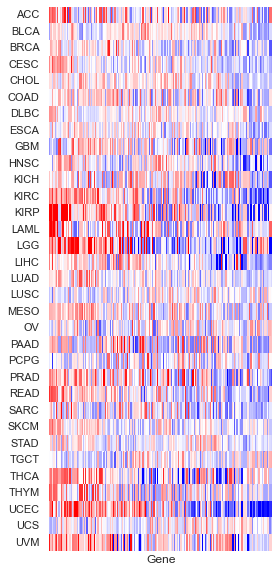

<Figure size 432x288 with 0 Axes>

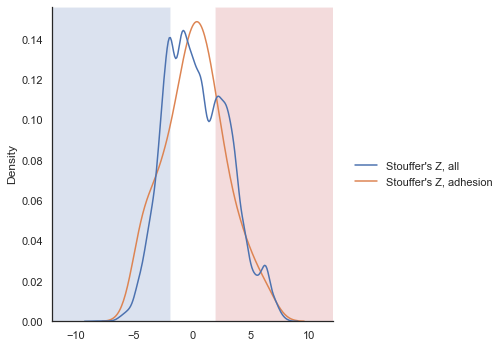

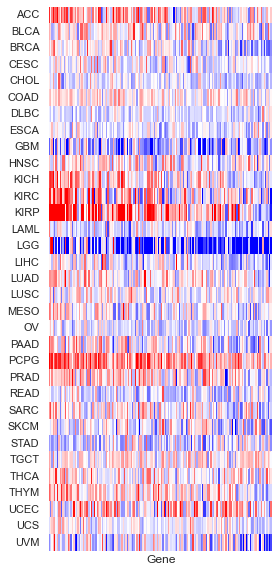

<Figure size 432x288 with 0 Axes>

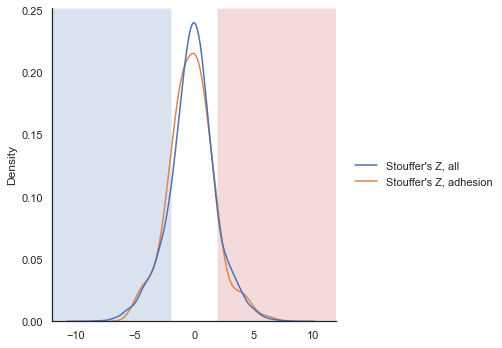

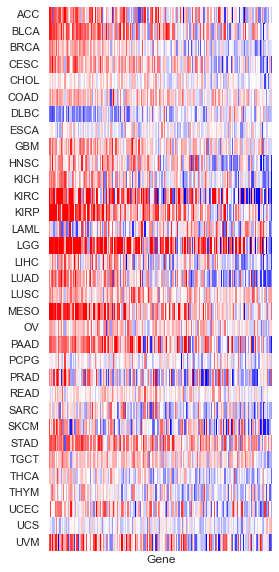

<Figure size 432x288 with 0 Axes>

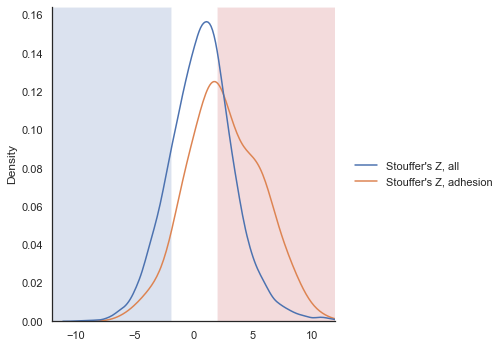

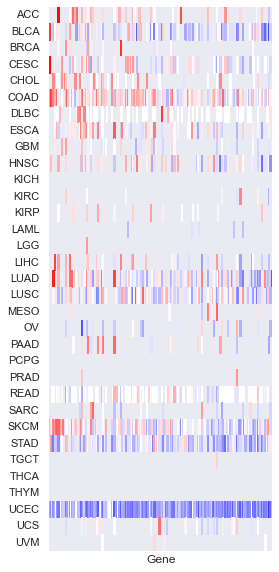

<Figure size 432x288 with 0 Axes>

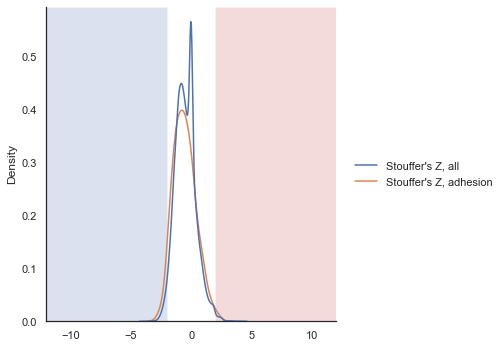

In [25]:
# import of the data for the file named 'f' in the cell above 
# loop through the sheets in the list 'sheet' 
# for all of these: sort according to Stouffer Z and filter according to a chosen subset of genes
# and create a new overview file (ovw) that contains a summary of all significant and unsignficant genes,
# a new excel sheet for each feature with only the genes from the subset, as well as a distribution plot
# of these genes compared to the full list and a heatmap of the Z scores

df_o_tot = pd.DataFrame()
df = pd.DataFrame()
df_store = pd.DataFrame()

# loop through the excel data sheets in the list 'sheet' created in the cell above
for index,i in enumerate(sheet):
    
    #names for output files and plots; 
    #if not pdf wanted: change here accordingly
    #and give value when calling plot functions to avoid default value pdf
    name_h = i[6:] + '_heatmap.pdf'  
    name_z = i[6:] + '_z-dis.pdf'
    name_e = i[6:] + '_data.xlsx'
    
    #call the function create_df to create dataframe from excelsheet provided by TCGA survival and 
    #for feature defined in first cell of this notebook (i.e. CNA, Gene expression, etc). Additionally, 
    #the gene names are corrected by deleting the preceeding " ' "
    df=create_df(f,i)
    
    #call the function sort_df and sort datasheet according to column with "Stouffer's Z" as default; other options
    #for sorting are the abbreviations of the different cancer types, e.g. "GBM" for glioblastoma multiform
    df=sort_df(df)
    
    #create list of genes
    #options: adh_lst (self createad, all ITGs, ligands, core adhesome), 
    #matris_lst (Naba's matrisome list), filopod_lst (Jacquemet et al, markers for filopodia),
    #nf_lst and caf_lst (marker for normal fibroblasts or cafs from Sharma et al 2022 SciSig)
    adh=adh_lst()  
    
    #call a function to create new df only with genes found in list created before
    df_a=filter_adh(df,adh)
    
    #reduce analysis to cancer subset, all cancer types as default (meaning that df won't be changed, 
    #car_lst for carcinoma, no_car_lst for all others
    #df_a=cancer_set(df,car_lst)
    
    #quality check that every gene in the last is found in the excel sheet
    #if index == 2:
     #   check_gene(df,adh)
    
    #call the function to create new excel sheet that contains nr of signifcant fav and unfav marker from list
    df_o = ovw_df(df_a, i[5:])    
    if index == 0:
        df_o_tot = df_o
    elif index >= 1:
        df_o_tot = merge(df_o_tot,df_o)
    
    #call the function to create new excel sheet that contains all Z scores for genes found in list
    df_a.to_excel(name_e)
    
    #call the function to plot Z-scores from genes in list as heatmap, pdf is set as default
    plot_heat(df_a,name_h)
    
    #call the function to plot distribution of Z-scores (Stouffer's Z) of all genes and selected genes, 
    #pdf is set as default
    plot_z_dis(df,df_a,name_z)
    
    if index == 2:
        df_store = df_a
# write the overview data into a new excel file    
df_o_tot.to_excel('ovw_signficance.xlsx')